In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
path_base = "libor_only.xlsx"
path_sofr = "sofr_only.xlsx"

def rename(path):
    """
    @Arg:
    path: path to file
    
    @Return:
    The raw data is terrible, return a better one where column names are sheet names of each
    """
    df_dict = pd.read_excel(path, sheet_name = None, index_col=0)
    df = pd.concat(df_dict.values(), axis=1)
    df.columns = list(df_dict.keys())
    
    return df
    

def merge_sofr(drop, path_base, path_sofr, libor = ["3mo_libor", "1mo_libor"]):
    """
    @Arg:
    drop: if we drop all NA
    path_base: path to the table of all basic data as well as libor
    path_sofr: path to table of sofr data
    libor: colname of libor, it will be used when we are updating them according with sofr
    
    @Return:
    Return a concatenated table of based on libor and sofr.
    Older data are with libor, and the newer one are replaced by sofr
    """
    
    df_base = rename(path_base)
    df_sofr = rename(path_sofr)
    #display(df_base)
    #display(df_sofr)
    
    df_sofr.columns = libor
    df_base.update(df_sofr)
    
    if drop:
        df_base = df_base.dropna(axis=0, how="any")
        df_base = df_base.reset_index(drop=True)
    
    return df_base

In [3]:
df = merge_sofr(True, path_base, path_sofr)

In [4]:
display(df)

,20yr,30yr,10yr,5yr,2yr,1yr,6mo,3mo_libor,1mo_libor,1d
0,1.1522,1.3860,0.6720,0.3383,0.1653,0.1523,0.1395,0.08740,0.06813,0.05
1,1.1224,1.3705,0.6591,0.3334,0.1676,0.1497,0.1344,0.08756,0.06968,0.05
2,1.1974,1.4446,0.6965,0.3478,0.1717,0.1624,0.1420,0.08947,0.07484,0.05
3,1.1947,1.4399,0.6819,0.3478,0.1799,0.1751,0.1674,0.08958,0.07576,0.05
4,1.2063,1.4519,0.6900,0.3384,0.1701,0.1624,0.1624,0.08968,0.07625,0.05
...,...,...,...,...,...,...,...,...,...,...
600,4.3933,4.1414,4.0123,4.1844,4.4142,4.5294,4.4756,4.43957,3.76771,3.08
601,4.4038,4.1639,4.0478,4.2283,4.4824,4.6019,4.5359,4.46029,3.80486,3.08
602,4.3558,4.0919,4.0419,4.2670,4.5447,4.6258,4.5838,4.45971,3.84157,3.08
603,4.4223,4.1405,4.1005,4.3093,4.6197,4.6945,4.5520,4.50843,3.83571,3.08


<AxesSubplot: >

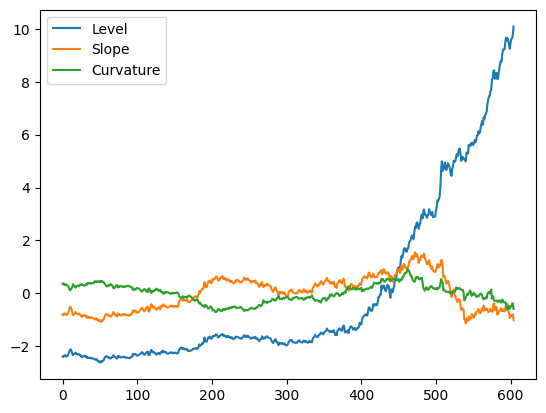

In [5]:
pca = PCA(n_components=3)
components = pca.fit_transform(df)
df_components = pd.DataFrame(data=components, columns=['Level', 'Slope', 'Curvature'])
df_components.plot() #???

# CIR

In [6]:
from dataclasses import dataclass
from typing import Optional, NoReturn


@dataclass
class CIRParams:
    """CIR process params, 2ab has to be larger or equal then c^2."""

    a: float  # mean reversion parameter
    b: float  # asymptotic mean
    c: float  # Brownian motion scale factor (standard deviation)

    def __post_init__(self) -> Optional[NoReturn]:
        if 2 * self.a * self.b < self.c ** 2:
            raise ValueError("2ab has to be less than or equal to c^2.")
        return None

In [7]:
from typing import Optional, NoReturn, Any

import numpy as np

import brownian_motion

def get_CIR_process(
    T: int,
    CIR_params: CIRParams,
    sigma_0: Optional[float] = None,
    random_state: Optional[int] = None,
) -> np.ndarray:
    """
    - T is the sample size.
    - CIR_params is an instance of CIRParams dataclass.
    - sigma_0 the initial value for the process, if None, then sigma_0 is taken
        to be b (the asymptotic mean).
    Returns a 1D array.
    """
    dW = brownian_motion.get_dW(T, random_state)
    return _generate_CIR_process(dW, CIR_params, sigma_0)


def _generate_CIR_process(
    dW: np.ndarray,
    CIR_params: CIRParams,
    sigma_0: Optional[float] = None,
) -> np.ndarray:
    """
    Generate the CIR process given the Brownian motion.
    - dW is a 1D array with the Brownian motion increments.
    - CIR_params is an instance of CIRParams dataclass.
    - sigma_0 the initial value for the process, if None, then sigma_0 is taken
        to be b (the asymptotic mean).
    Returns a 1D array.
    """
    T = len(dW)
    _sigma_0 = _select_sigma_0(sigma_0, CIR_params)
    sigma_t = [_sigma_0]
    for t in range(1, T):
        dsigma_t = (
            CIR_params.a * (CIR_params.b - sigma_t[t - 1])
            + CIR_params.c * np.sqrt(sigma_t[t - 1]) * dW[t]
        )
        # if Nan in simulation raise an error.
        _validate_not_nan(dsigma_t)
        sigma_t.append(sigma_t[t - 1] + dsigma_t)
    return np.asarray(sigma_t)


def _select_sigma_0(
    sigma_0_in: Optional[float], CIR_params: CIRParams
) -> float:
    """Returns sigma_0input if not None, else b (the long term mean)."""
    if sigma_0_in is not None:
        return sigma_0_in
    return CIR_params.b


def _validate_not_nan(dsigma_t: Any) -> Optional[NoReturn]:
    if np.isnan(dsigma_t):
        raise ValueError(
            "CIR process simulation crashed, check your CIR_params. "
            + "Maybe choose a smaller c value."
        )
    return None

In [8]:
import numpy as np
from sklearn.linear_model import LinearRegression


def estimate_CIR_params(sigma_t: np.ndarray) -> CIRParams:
    """
    Estimate CIR params from OLS regression.
    - sigma_t is 1D array.
    Returns instance of CIRParams.
    """
    # define regression specification
    sigma_sqrt = np.sqrt(sigma_t[:-1])
    y = np.diff(sigma_t) / sigma_sqrt
    x1 = 1.0 / sigma_sqrt
    x2 = sigma_sqrt
    X = np.concatenate([x1.reshape(-1, 1), x2.reshape(-1, 1)], axis=1)
    # regression model
    reg = LinearRegression(fit_intercept=False)
    reg.fit(X, y)
    # regression coefficients
    ab = reg.coef_[0]
    a = -reg.coef_[1]
    b = ab / a
    # residuals and their standard deviation
    y_hat = reg.predict(X)
    c = np.std(y - y_hat)
    return CIRParams(a, b, c)

# OU

In [9]:
from dataclasses import dataclass
from typing import Optional, NoReturn


@dataclass
class OUParams:
    """OU process params."""

    a: float  # mean reversion parameter
    b: float  # asymptotic mean
    c: float

In [10]:
from typing import Optional, NoReturn, Any

import numpy as np

import brownian_motion

def get_OU_process(
    T: int,
    OU_params: OUParams,
    sigma_0: Optional[float] = None,
    random_state: Optional[int] = None,
) -> np.ndarray:
    """
    - T is the sample size.
    - OU_params is an instance of OUParams dataclass.
    - sigma_0 the initial value for the process, if None, then sigma_0 is taken
        to be b (the asymptotic mean).
    Returns a 1D array.
    """
    dW = brownian_motion.get_dW(T, random_state)
    #print(dW)
    return _generate_OU_process(dW, OU_params, sigma_0)


def _generate_OU_process(
    dW: np.ndarray,
    OU_params: OUParams,
    sigma_0: Optional[float] = None,
) -> np.ndarray:
    """
    Generate the OU process given the Brownian motion.
    - dW is a 1D array with the Brownian motion increments.
    - OU_params is an instance of OUParams dataclass.
    - sigma_0 the initial value for the process, if None, then sigma_0 is taken
        to be b (the asymptotic mean).
    Returns a 1D array.
    """
    T = len(dW)
    _sigma_0 = _select_sigma_0(sigma_0, OU_params)
    sigma_t = [_sigma_0]
    for t in range(1, T):
        dsigma_t = (
            OU_params.a * (OU_params.b - sigma_t[t - 1]) + OU_params.c * dW[t]
        )
        # if Nan in simulation raise an error.
        #_validate_not_nan(dsigma_t)
        sigma_t.append(sigma_t[t - 1] + dsigma_t)
    return np.asarray(sigma_t)


def _select_sigma_0(
    sigma_0_in: Optional[float], OU_params: OUParams
) -> float:
    """Returns sigma_0input if not None, else b (the long term mean)."""
    if sigma_0_in is not None:
        return sigma_0_in
    return OU_params.b


#def _validate_not_nan(dsigma_t: Any) -> Optional[NoReturn]:
#    if np.isnan(dsigma_t):
#        raise ValueError(
#            "OU process simulation crashed, check your OU_params. "
#            + "Maybe choose a smaller c value."
#        )
#    return None

In [11]:
import numpy as np
from sklearn.linear_model import LinearRegression


def estimate_OU_params(sigma_t: np.ndarray) -> OUParams:
    """
    Estimate OU params from OLS regression.
    - sigma_t is 1D array.
    Returns instance of CIRParams.
    """
    # define regression specification
    sigma = sigma_t[:-1]
    y = np.diff(sigma_t)
    x2 = sigma
    x1 = np.array([1.0]*len(x2))
    X = np.concatenate([x1.reshape(-1, 1), x2.reshape(-1, 1)], axis=1)
    # regression model
    reg = LinearRegression(fit_intercept=False)
    reg.fit(X, y)
    # regression coefficients
    ab = reg.coef_[0]
    a = -reg.coef_[1]
    b = ab / a
    # residuals and their standard deviation
    y_hat = reg.predict(X)
    c = np.std(y - y_hat)
    return OUParams(a, b, c)

<AxesSubplot: >

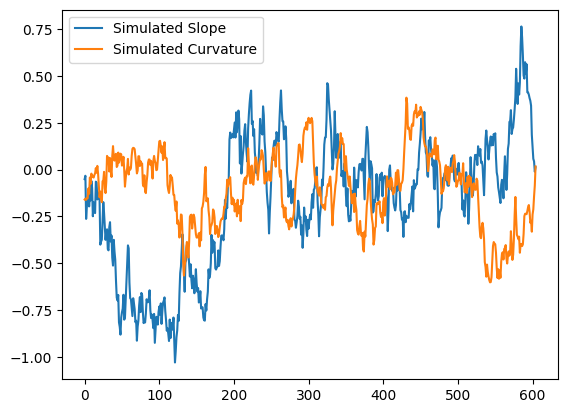

In [12]:
proc_slope = df_components.Slope.to_numpy()
proc_curvature = df_components.Curvature.to_numpy()

est_param_slope = estimate_OU_params(proc_slope)
est_param_curvature = estimate_OU_params(proc_curvature)
#print(est_param_slope)
#print(est_param_curvature)

sim_slope = get_OU_process(len(df_components), est_param_slope)
sim_curvature = get_OU_process(len(df_components), est_param_curvature)

#x1 = np.linspace(0,len(df_components)-1,len(df_components))
#x2 = np.linspace(0,len(df_components)-1,len(df_components))
#plt.plot(x1, sim_slope)
#plt.plot(x2, sim_curvature)
#plt.show()

temp = pd.DataFrame({"Simulated Slope": sim_slope, "Simulated Curvature": sim_curvature})
temp.plot()

#plt.plot(sim_curvature)